<a href="https://colab.research.google.com/github/xuzihan125/DataMining/blob/master/assignment-07/logisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!rm -rf *
!wget -nc https://course.ccs.neu.edu/cs6220/fall2023/homework-7/data/titanic/titanic.test.csv
!wget -nc https://course.ccs.neu.edu/cs6220/fall2023/homework-7/data/titanic/titanic.train.csv
!wget -nc https://course.ccs.neu.edu/cs6220/fall2023/homework-7/data/titanic/arxiv/titanic.test.labels.csv
# !wget -nc https://course.ccs.neu.edu/cs6220/fall2023/homework-7/data/titanic/titanic.test.csv




--2023-11-21 10:34:50--  https://course.ccs.neu.edu/cs6220/fall2023/homework-7/data/titanic/titanic.test.csv
Resolving course.ccs.neu.edu (course.ccs.neu.edu)... 129.10.117.35
Connecting to course.ccs.neu.edu (course.ccs.neu.edu)|129.10.117.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35145 (34K) [text/csv]
Saving to: ‘titanic.test.csv’

titanic.test.csv    100%[===================>]  34.32K   197KB/s    in 0.2s    

2023-11-21 10:34:51 (197 KB/s) - ‘titanic.test.csv’ saved [35145/35145]

--2023-11-21 10:34:51--  https://course.ccs.neu.edu/cs6220/fall2023/homework-7/data/titanic/titanic.train.csv
Resolving course.ccs.neu.edu (course.ccs.neu.edu)... 129.10.117.35
Connecting to course.ccs.neu.edu (course.ccs.neu.edu)|129.10.117.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73203 (71K) [text/csv]
Saving to: ‘titanic.train.csv’

titanic.train.csv   100%[===================>]  71.49K   197KB/s    in 0.4s    

2023-11-21 10:34:52

In [3]:
import numpy as np
import pandas as pd
data_train = pd.read_csv("titanic.train.csv")
data_test = pd.read_csv("titanic.test.csv", index_col=0)

pclass_type = []
sibsp_type = []
parch_type = []
cabin_type = []
embarked_type = []

age_avg = 0
age_max = 0
age_min = 0
fare_avg = 0
fare_min = 0
fare_max = 0


avg_cabin = 0

# to be normalized: age, fare
# to be split: embarked, cabin



def preprocessed(data, train=True, order = None):
  global age_avg, age_max, age_min, fare_avg, fare_min, fare_max, avg_cabin, pclass_type, sibsp_type, parch_type, cabin_type, embarked_type

  def split_func(row, name, checker):
    if row.isna()[name]:
      return row
    if train:
      if name+'_'+str(row[name]) not in checker:
        checker.append(name+'_'+str(row[name]))
    else:
      if name+'_'+str(row[name]) not in checker:
        return row
    row[name+'_'+str(row[name])] = 1
    return row

  def get_param(column):
    return column.mean(), column.max(), column.min()

  # pick usable data
  data_denamed = data[["pclass", "survived", "sex", "age", "sibsp", "parch", "fare", "cabin", "embarked"]].copy()
  # data_denamed = data[["pclass", "survived", "sex", "age", "fare", "cabin", "embarked"]].copy()

  # split pclass
  if not train:
    for item in pclass_type:
      data_denamed[item] = 0
  data_denamed = data_denamed.apply(lambda x : split_func(x, "pclass", pclass_type), axis=1)
  data_denamed.drop("pclass",inplace=True, axis=1)

  #transfer sex
  data_denamed['sex'] = data_denamed['sex'].apply(lambda x : 1 if x == "female" else 0)

  #normalize age
  if train:
    age_avg, age_max, age_min = get_param(data_denamed['age'])
  data_denamed['age'].fillna(age_avg, inplace=True)
  data_denamed['age'] = data_denamed['age'].apply(lambda x : (x-age_min)/(age_max-age_min))

  #split sibsp
  if not train:
    for item in sibsp_type:
      data_denamed[item] = 0
  data_denamed = data_denamed.apply(lambda x : split_func(x, "sibsp", sibsp_type), axis=1)
  data_denamed.drop("sibsp",inplace=True, axis=1)

  #split parch
  if not train:
    for item in parch_type:
      data_denamed[item] = 0
  data_denamed = data_denamed.apply(lambda x : split_func(x, "parch", parch_type), axis=1)
  data_denamed.drop("parch",inplace=True, axis=1)

  # normalize fare
  if train:
    fare_avg, fare_max, fare_min= get_param(data_denamed['fare'])
  data_denamed['fare'].fillna(fare_avg, inplace=True)
  data_denamed['fare'] = data_denamed['fare'].apply(lambda x : (x-fare_min)/(fare_max-fare_min))

  # split cabin
  data_denamed['cabin'] = data_denamed['cabin'].apply(lambda x:x[0] if isinstance(x, str) else x)
  if not train:
    for item in cabin_type:
      data_denamed[item] = 0
  # if train:
  #   avg_cabin = data_denamed['cabin'].mean()
  data_denamed = data_denamed.apply(lambda x : split_func(x, "cabin", cabin_type), axis=1)
  data_denamed.drop("cabin",inplace=True, axis=1)
  # data_denamed['cabin'] = data_denamed['cabin'].astype(float)
  # data_denamed['cabin'] = data_denamed['cabin'].fillna(avg_cabin)

  # embarked
  if not train:
    for item in embarked_type:
      data_denamed[item] = 0
  data_denamed = data_denamed.apply(lambda x : split_func(x, "embarked", embarked_type), axis=1)
  data_denamed.drop("embarked",inplace=True, axis=1)
  # map = {'S':0, 'Q':0.5, 'C':1}
  # data_denamed['embarked'] = data_denamed['embarked'].fillna('S')
  # data_denamed['embarked'] = data_denamed['embarked'].apply(lambda x: map[x] if x else 0)
  data_denamed['b'] = 1
  data_denamed.fillna(0, inplace=True)
  if not train:
    data_denamed = data_denamed.reindex(columns=order)
  return data_denamed


def split(data):
  return data['survived'].values, data.drop(columns=['survived']).values

train_data_processed = preprocessed(data_train)
data_train_processed_y, data_train_processed_x = split(train_data_processed)
data_test_processed_y, data_test_processed_x = split(preprocessed(data_test, train=False, order=train_data_processed.columns))
# data_processed = preprocessed(data)

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD

def train_model(train_x, train_y, test_x, test_y, model, epochs=40):
  opt = SGD(learning_rate=0.1)
  model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
  result = model.fit(train_x, train_y, epochs=epochs, validation_data=(test_x, test_y))
  score = model.evaluate(test_x, test_y, verbose=0)
  # print(result.history)
  print("Test loss:", score[0])
  print("Test accuracy:", score[1])
  return model, score, result

num_classes = 1
input_shape = len(data_train_processed_x[0])
model = keras.Sequential(
    [
    keras.Input(shape=input_shape),
    layers.Dense(num_classes, activation="sigmoid"),
    ]
)
model, score, result = train_model(data_train_processed_x, data_train_processed_y, data_test_processed_x, data_test_processed_y, model)


Epoch 1/40
28/28 [==============================] - 1s 10ms/step - loss: 0.6316 - accuracy: 0.6622 - val_loss: 0.5914 - val_accuracy: 0.7249
Epoch 2/40
28/28 [==============================] - 0s 5ms/step - loss: 0.5862 - accuracy: 0.7217 - val_loss: 0.5571 - val_accuracy: 0.7751
Epoch 3/40
28/28 [==============================] - 0s 8ms/step - loss: 0.5573 - accuracy: 0.7598 - val_loss: 0.5306 - val_accuracy: 0.7895
Epoch 4/40
28/28 [==============================] - 0s 8ms/step - loss: 0.5374 - accuracy: 0.7632 - val_loss: 0.5124 - val_accuracy: 0.7847
Epoch 5/40
28/28 [==============================] - 0s 5ms/step - loss: 0.5241 - accuracy: 0.7666 - val_loss: 0.5025 - val_accuracy: 0.7751
Epoch 6/40
28/28 [==============================] - 0s 3ms/step - loss: 0.5144 - accuracy: 0.7654 - val_loss: 0.4911 - val_accuracy: 0.7823
Epoch 7/40
28/28 [==============================] - 0s 5ms/step - loss: 0.5067 - accuracy: 0.7609 - val_loss: 0.4850 - val_accuracy: 0.7775
Epoch 8/40
28/28 [=

display of the accuracy curve on train set, accuracy curve on test set, and loss curve,

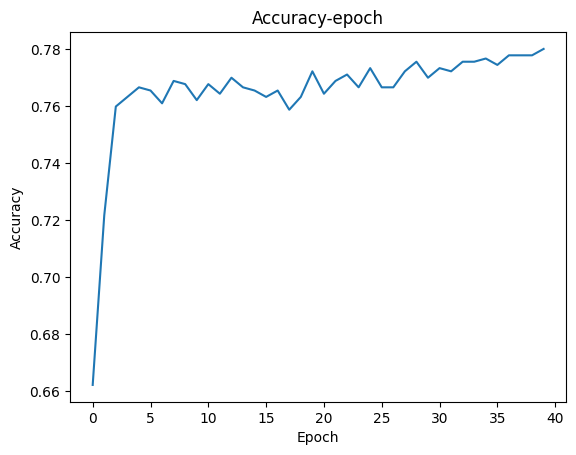

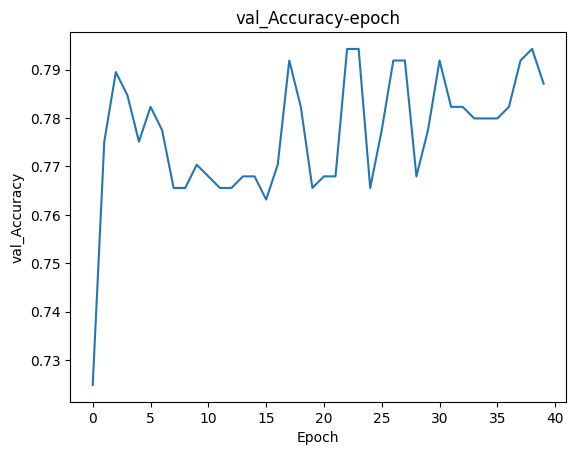

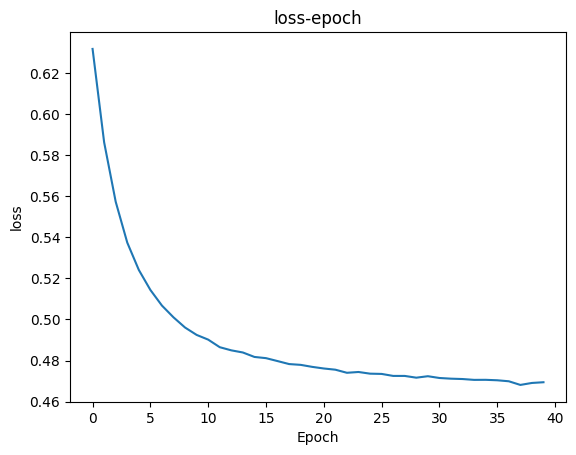

In [5]:
import matplotlib.pyplot as plt

def plot(result):
  plt.plot(range(len(result.history["accuracy"])), result.history["accuracy"])
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title("Accuracy-epoch")
  plt.show()

  plt.plot(range(len(result.history["val_accuracy"])), result.history["val_accuracy"])
  plt.xlabel("Epoch")
  plt.ylabel("val_Accuracy")
  plt.title("val_Accuracy-epoch")
  plt.show()

  plt.plot(range(len(result.history["loss"])), result.history["loss"])
  plt.xlabel("Epoch")
  plt.ylabel("loss")
  plt.title("loss-epoch")
  plt.show()

plot(result)

Epoch 1/40
28/28 [==============================] - 1s 10ms/step - loss: 0.6499 - accuracy: 0.6341 - val_loss: 0.5968 - val_accuracy: 0.7368
Epoch 2/40
28/28 [==============================] - 0s 4ms/step - loss: 0.5921 - accuracy: 0.7228 - val_loss: 0.5360 - val_accuracy: 0.7895
Epoch 3/40
28/28 [==============================] - 0s 5ms/step - loss: 0.5351 - accuracy: 0.7643 - val_loss: 0.4800 - val_accuracy: 0.8062
Epoch 4/40
28/28 [==============================] - 0s 4ms/step - loss: 0.4994 - accuracy: 0.7699 - val_loss: 0.4573 - val_accuracy: 0.8062
Epoch 5/40
28/28 [==============================] - 0s 5ms/step - loss: 0.4782 - accuracy: 0.7789 - val_loss: 0.4495 - val_accuracy: 0.7990
Epoch 6/40
28/28 [==============================] - 0s 5ms/step - loss: 0.4725 - accuracy: 0.7800 - val_loss: 0.4320 - val_accuracy: 0.8110
Epoch 7/40
28/28 [==============================] - 0s 5ms/step - loss: 0.4666 - accuracy: 0.7778 - val_loss: 0.4267 - val_accuracy: 0.7967
Epoch 8/40
28/28 [=

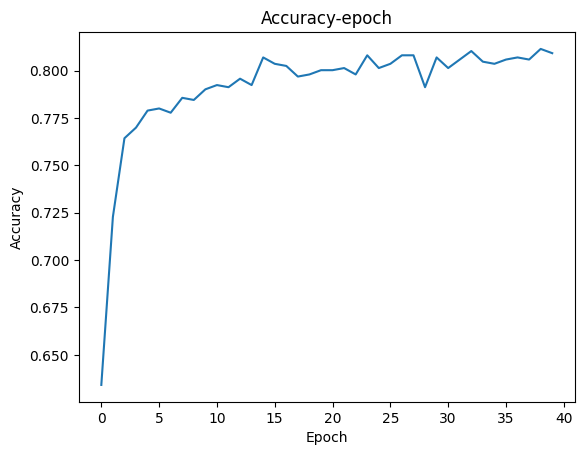

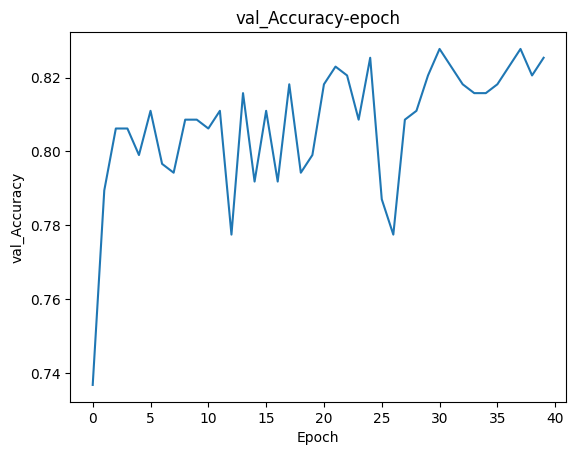

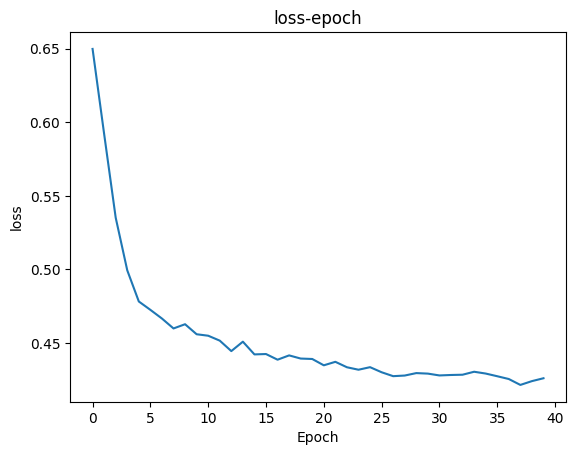

In [6]:
model_3 = keras.Sequential(
    [
    keras.Input(shape=input_shape),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(num_classes, activation="sigmoid"),
    ]
)
model_3, score_3, result_3 = train_model(data_train_processed_x, data_train_processed_y, data_test_processed_x, data_test_processed_y, model_3)
plot(result_3)


Epoch 1/40
28/28 [==============================] - 1s 12ms/step - loss: 0.6764 - accuracy: 0.5915 - val_loss: 0.6487 - val_accuracy: 0.6531
Epoch 2/40
28/28 [==============================] - 0s 5ms/step - loss: 0.6423 - accuracy: 0.6207 - val_loss: 0.5964 - val_accuracy: 0.7010
Epoch 3/40
28/28 [==============================] - 0s 5ms/step - loss: 0.5844 - accuracy: 0.7239 - val_loss: 0.5327 - val_accuracy: 0.7775
Epoch 4/40
28/28 [==============================] - 0s 6ms/step - loss: 0.5240 - accuracy: 0.7609 - val_loss: 0.4825 - val_accuracy: 0.7751
Epoch 5/40
28/28 [==============================] - 0s 4ms/step - loss: 0.4956 - accuracy: 0.7654 - val_loss: 0.4706 - val_accuracy: 0.7632
Epoch 6/40
28/28 [==============================] - 0s 4ms/step - loss: 0.4828 - accuracy: 0.7834 - val_loss: 0.4650 - val_accuracy: 0.7727
Epoch 7/40
28/28 [==============================] - 0s 6ms/step - loss: 0.4736 - accuracy: 0.7778 - val_loss: 0.4404 - val_accuracy: 0.8110
Epoch 8/40
28/28 [=

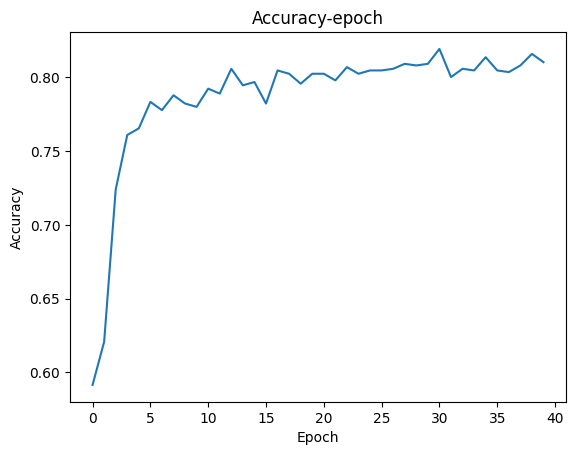

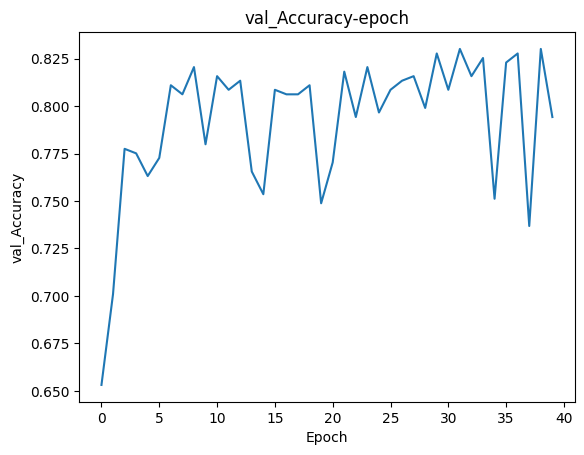

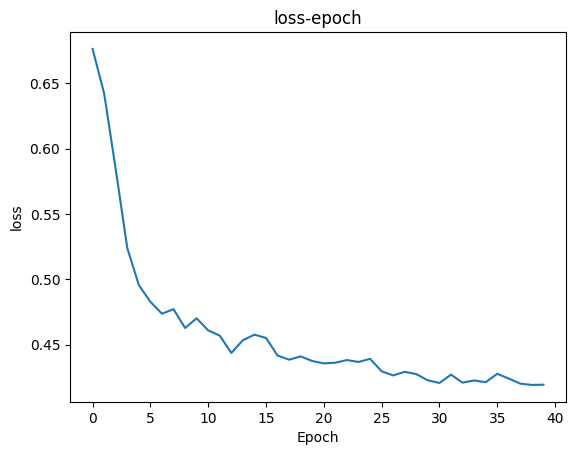

In [7]:
model_5 = keras.Sequential(
    [
    keras.Input(shape=input_shape),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(num_classes, activation="sigmoid"),
    ]
)
model_5, score_5, result_5 = train_model(data_train_processed_x, data_train_processed_y, data_test_processed_x, data_test_processed_y, model_5)
plot(result_5)

Epoch 1/40
28/28 [==============================] - 1s 9ms/step - loss: 0.4153 - accuracy: 0.8137 - val_loss: 0.4249 - val_accuracy: 0.8254
Epoch 2/40
28/28 [==============================] - 0s 5ms/step - loss: 0.4184 - accuracy: 0.8171 - val_loss: 0.4359 - val_accuracy: 0.8325
Epoch 3/40
28/28 [==============================] - 0s 4ms/step - loss: 0.4072 - accuracy: 0.8171 - val_loss: 0.5042 - val_accuracy: 0.7632
Epoch 4/40
28/28 [==============================] - 0s 5ms/step - loss: 0.4171 - accuracy: 0.8227 - val_loss: 0.4483 - val_accuracy: 0.8254
Epoch 5/40
28/28 [==============================] - 0s 5ms/step - loss: 0.4072 - accuracy: 0.8182 - val_loss: 0.4259 - val_accuracy: 0.8278
Epoch 6/40
28/28 [==============================] - 0s 4ms/step - loss: 0.4142 - accuracy: 0.8227 - val_loss: 0.4255 - val_accuracy: 0.8254
Epoch 7/40
28/28 [==============================] - 0s 4ms/step - loss: 0.4084 - accuracy: 0.8204 - val_loss: 0.4592 - val_accuracy: 0.7990
Epoch 8/40
28/28 [==

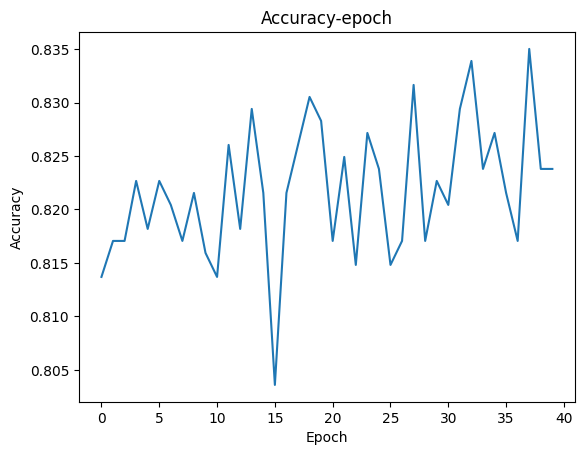

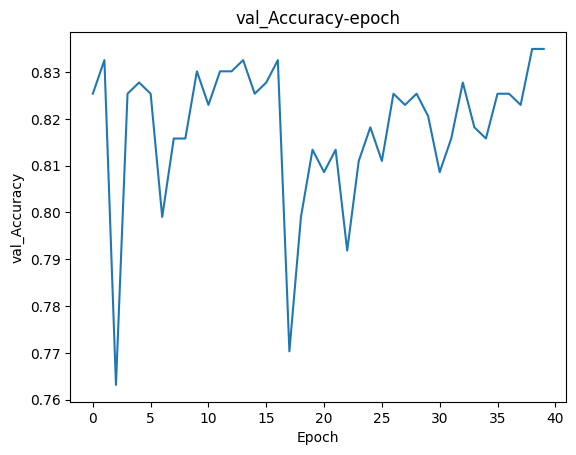

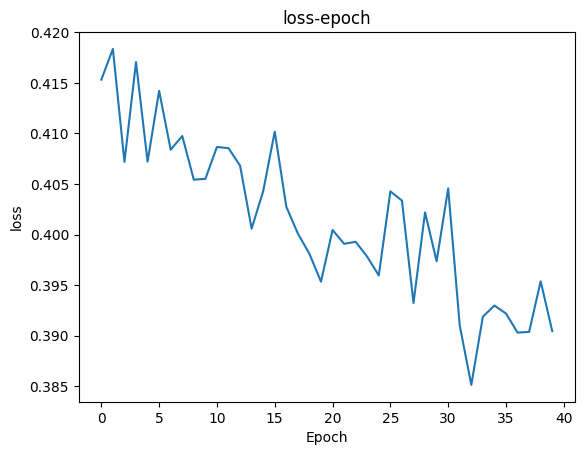

In [9]:
model_7 = keras.Sequential(
    [
    keras.Input(shape=input_shape),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(num_classes, activation="sigmoid"),
    ]
)
model_7, score_7, result_7 = train_model(data_train_processed_x, data_train_processed_y, data_test_processed_x, data_test_processed_y, model_5)
plot(result_7)

display of the accuracy with different layers

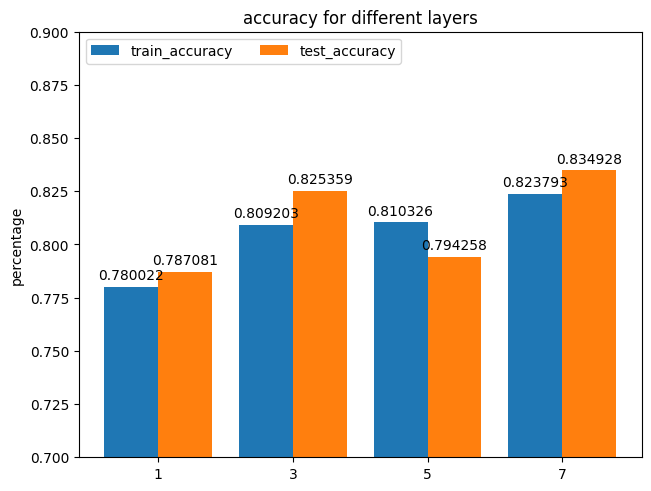

In [17]:
size = 4
layers = [1,3,5,7]
train_accuracy = []
test_accuracy = []
x = np.arange(len(layers))
width = 0.4

train_accuracy.append(result.history["accuracy"][39])
test_accuracy.append(result.history["val_accuracy"][39])

train_accuracy.append(result_3.history["accuracy"][39])
test_accuracy.append(result_3.history["val_accuracy"][39])

train_accuracy.append(result_5.history["accuracy"][39])
test_accuracy.append(result_5.history["val_accuracy"][39])

train_accuracy.append(result_7.history["accuracy"][39])
test_accuracy.append(result_7.history["val_accuracy"][39])

fig, ax = plt.subplots(layout='constrained')
move = 0
rects = ax.bar(x, train_accuracy, width, label="train_accuracy")
ax.bar_label(rects, padding=3)
rects = ax.bar(x+width, test_accuracy, width, label="test_accuracy")
ax.bar_label(rects, padding=3)


ax.set_ylabel('percentage')
ax.set_title('accuracy for different layers')
ax.set_xticks(x + 0.5*width, layers)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0.7, 0.9)

plt.show()